In [31]:
# Import libraries
from numpy.random import seed

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

In [6]:
# get directories
print(os.getcwd())
print(os.listdir())

C:\cygwin64\home\salis\git\repos\DSC680\breast-cancer
['.ipynb_checkpoints', 'data', 'Untitled.ipynb']


In [7]:
print(os.listdir('./data/'))

['test', 'test.zip', 'train', 'train.zip', 'train_labels.csv', 'train_labels.csv.zip']


In [10]:
# how many images?
print(len(os.listdir('./data/test')))
print(len(os.listdir('./data/train')))

57458
220026


In [11]:
# load the training labels
train_df = pd.read_csv('./data/train_labels.csv')

In [13]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


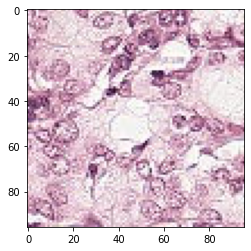

In [15]:
# from research, these two images are noted as causing issues
# dd6dfed324f9fcb6f93f46f32fc800f2ec196be2
# 9369c7278ec8bcc6c880d99194de09fc2bd4efbe
img = mpimg.imread('./data/train/dd6dfed324f9fcb6f93f46f32fc800f2ec196be2.tif')
imgplot = plt.imshow(img)


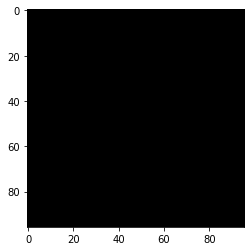

In [16]:
img = mpimg.imread('./data/train/9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif')
imgplot = plt.imshow(img)

In [20]:
# remove images noted above
train_df = train_df[train_df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
train_df = train_df[train_df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

In [21]:
print(train_df.shape)

(220023, 2)


In [22]:
train_df['label'].value_counts()

0    130907
1     89116
Name: label, dtype: int64

In [23]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

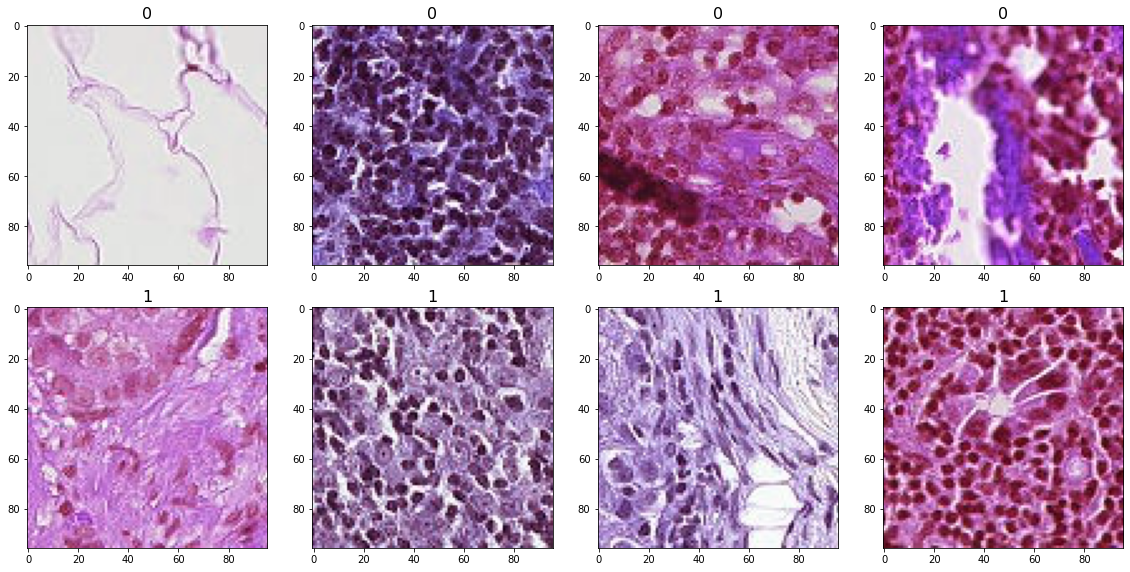

In [24]:
draw_category_images('label',4, train_df, './data/train/')

In [25]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

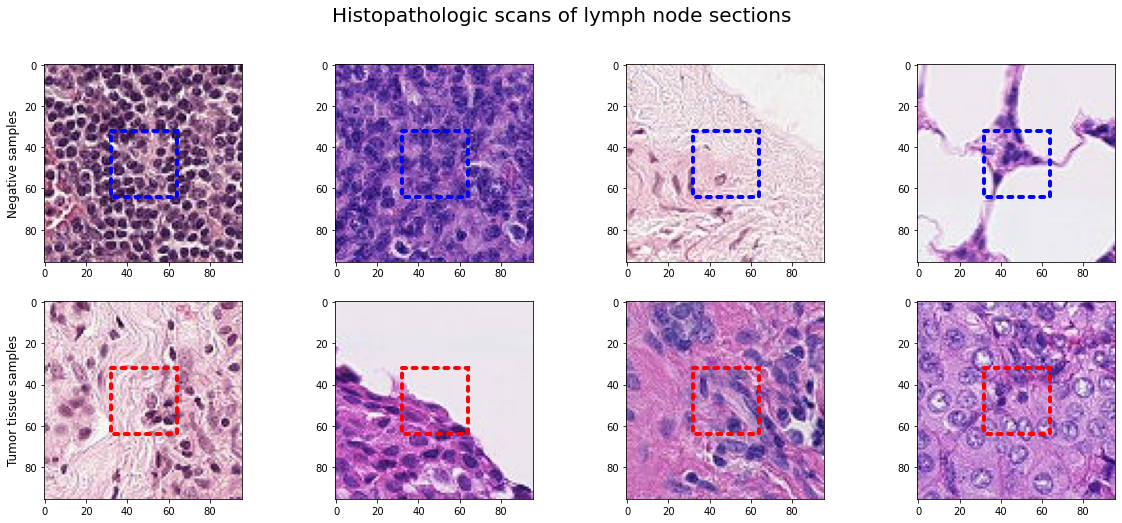

In [34]:
# random sampling
shuffled_data = shuffle(train_df)

fig, ax = plt.subplots(2,4, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:4]):
    path = os.path.join('./data/train/', idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')

# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:4]):
    path = os.path.join('./data/train/', idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')